# Notebook 2: Testing Various Models

In this notebook we test various models in two different ways:

1. Using the original train/valid/test split 
2. Using stratified cross-validation on all of the data

In the original paper the train and validation sets were balanced with respect to the class labels however the testing data is very imbalanced. The dataset on the whole is very imbalanced w.r.t. classes.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 8

In [2]:
import numpy as np
import pandas as pd
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.utils.extmath import softmax
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
def get_data():
    try:
        #
        original = pd.read_feather('../data/original.feather')
    except:
        # Get Original Data
        original = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header = None)

        # Fix columns
        original.columns = ['Elevation', 'Aspect', 'Slope',
               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
               'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
               'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
               'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
               'Cover_Type']

        for col, dtype in original.dtypes.iteritems():
            if dtype.name.startswith('int'):
                original[col] = pd.to_numeric(original[col], downcast ='integer')
            elif dtype.name.startswith('float'):
                original[col] = pd.to_numeric(original[col], downcast ='float')
        
        if not os.path.isdir('../data'):
            os.mkdir('../data')
        original.to_feather('../data/original.feather')
    return original

In [4]:
%%time
original = get_data()

# Get feature columns
features = [x for x in original.columns if x not in ['Id','Cover_Type']]
wilderness_cols = [x for x in features if x.startswith('Wild')]
soil_cols = [x for x in features if x.startswith('Soil')]
binary_cols = [x for x in features if x.startswith('Soil') or x in wilderness_cols]
numerical_cols = [x for x in features if x not in binary_cols]

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for summary scores
metrics = list()

Wall time: 49 ms


# Scoring Function

In [5]:
def train_original(sklearn_model, plot = True):
    
    # Original Training/Test Split
    X_temp = original[features].iloc[:15119]
    X_test = original[features].iloc[15119:]
    y_temp = original['Cover_Type'].iloc[:15119]
    y_test = original['Cover_Type'].iloc[15119:]
    
    # Store the out-of-fold predictions
    test_preds = np.zeros((X_test.shape[0],7))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_temp,y_temp)):
       
        # Training and Validation Sets
        X_train = X_temp.iloc[train_idx]
        X_valid = X_temp.iloc[valid_idx]
        y_train = y_temp.iloc[train_idx]
        y_valid = y_temp.iloc[valid_idx]
        
        # Create model
        start = time.time()
        model = clone(sklearn_model)
        model.fit(X_train, y_train)

        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict_proba(X_test)
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy: {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        time.sleep(0.5)
    
    test_preds = np.argmax(test_preds, axis = 1)
    holdout = accuracy_score(y_test, test_preds)
    print("\nAverage CV Accuracy:", round(scores.mean(), 5))
    print("Worst CV Accuracy:", round(scores.min(), 5))
    print('Holdout Accuracy:', round(holdout, 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    if plot:
        # Plot confusion matrix
        fig, ax = plt.subplots(figsize = (8,6))
        cm = confusion_matrix(y_test, test_preds, normalize = 'true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax = ax)
        plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
        plt.xlabel("Predicted Labels", fontsize=14)
        plt.ylabel("Actual Labels", fontsize=14)
        plt.show()
    
    return scores.mean(), test_preds, holdout

# Scikit-Learn Models

We test the following models from the scikit-learn library:

1. AdaBoost
2. ExtraTrees
3. Bagging
4. RandomForest
5. GradientBoosting
6. HistGradientBoosting

## 1. AdaBoostClassifier

In [6]:
# AdaBoost Classifier
adaboost_pipeline = make_pipeline(
    AdaBoostClassifier(
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.35344 in 7.52s.
Fold 1 Accuracy: 0.31323 in 7.53s.
Fold 2 Accuracy: 0.42169 in 7.44s.
Fold 3 Accuracy: 0.42063 in 7.46s.
Fold 4 Accuracy: 0.28413 in 7.42s.
Fold 5 Accuracy: 0.35767 in 7.42s.
Fold 6 Accuracy: 0.28519 in 7.41s.
Fold 7 Accuracy: 0.3298 in 7.44s.

Average CV Accuracy: 0.34572
Worst CV Accuracy: 0.28413
Holdout Accuracy: 0.26491
Training Time: 59.63s



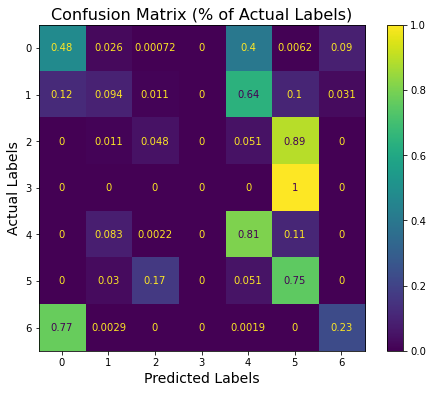

In [7]:
test_score, oof_preds, holdout = train_original(adaboost_pipeline)

metrics.append((
    'AdaBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. ExtraTrees

In [8]:
# ExtraTrees Classifier
extratrees_pipeline = make_pipeline(
    ExtraTreesClassifier(
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.86667 in 2.39s.
Fold 1 Accuracy: 0.86455 in 2.34s.
Fold 2 Accuracy: 0.86825 in 2.33s.
Fold 3 Accuracy: 0.86508 in 2.33s.
Fold 4 Accuracy: 0.86402 in 2.36s.
Fold 5 Accuracy: 0.84921 in 2.35s.
Fold 6 Accuracy: 0.87249 in 2.37s.
Fold 7 Accuracy: 0.87612 in 2.34s.

Average CV Accuracy: 0.8658
Worst CV Accuracy: 0.84921
Holdout Accuracy: 0.75364
Training Time: 18.8s



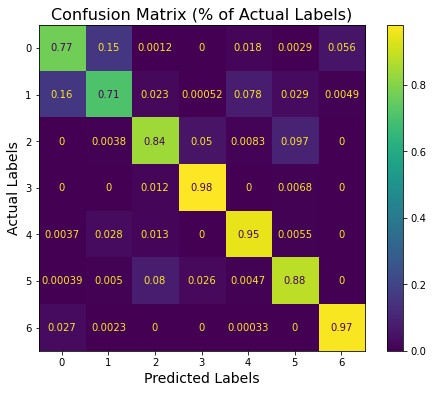

In [9]:
test_score, oof_preds, holdout = train_original(extratrees_pipeline)

metrics.append((
    'ExtraTrees', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. BaggingClassifier

In [10]:
# Bagging Classifier
bagging_pipeline = make_pipeline(
    BaggingClassifier(
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.83545 in 2.65s.
Fold 1 Accuracy: 0.82804 in 1.6s.
Fold 2 Accuracy: 0.8455 in 1.59s.
Fold 3 Accuracy: 0.8418 in 1.59s.
Fold 4 Accuracy: 0.84709 in 1.69s.
Fold 5 Accuracy: 0.83757 in 1.68s.
Fold 6 Accuracy: 0.84127 in 1.6s.
Fold 7 Accuracy: 0.85071 in 1.6s.

Average CV Accuracy: 0.84093
Worst CV Accuracy: 0.82804
Holdout Accuracy: 0.72876
Training Time: 14.01s



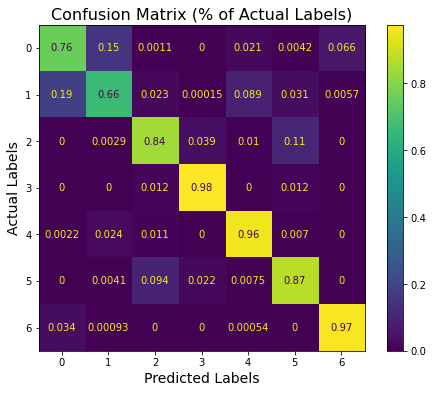

In [11]:
test_score, oof_preds, holdout = train_original(bagging_pipeline)

metrics.append((
    'Bagging', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. RandomForest

In [12]:
# Random Forest Classifier
randomforest_pipeline = make_pipeline(
    RandomForestClassifier(
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85608 in 2.23s.
Fold 1 Accuracy: 0.8619 in 2.2s.
Fold 2 Accuracy: 0.87354 in 2.19s.
Fold 3 Accuracy: 0.85661 in 2.2s.
Fold 4 Accuracy: 0.86032 in 2.2s.
Fold 5 Accuracy: 0.85185 in 2.21s.
Fold 6 Accuracy: 0.86772 in 2.2s.
Fold 7 Accuracy: 0.87083 in 2.19s.

Average CV Accuracy: 0.86236
Worst CV Accuracy: 0.85185
Holdout Accuracy: 0.74719
Training Time: 17.63s



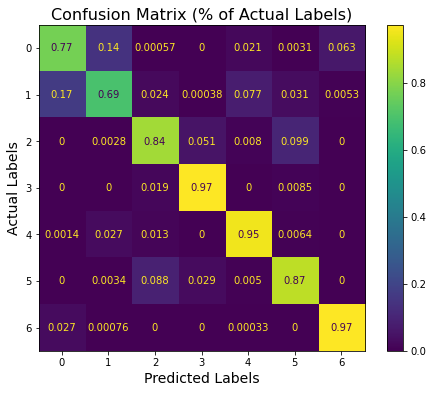

In [13]:
test_score, oof_preds, holdout = train_original(randomforest_pipeline)

metrics.append((
    'RandomForest', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 5. GradientBoosting

In [14]:
# Gradient Boosting Classifier
gbc_pipeline = make_pipeline(
    GradientBoostingClassifier(
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.79735 in 21.82s.
Fold 1 Accuracy: 0.78307 in 21.7s.
Fold 2 Accuracy: 0.79788 in 21.97s.
Fold 3 Accuracy: 0.80423 in 21.82s.
Fold 4 Accuracy: 0.80053 in 22.13s.
Fold 5 Accuracy: 0.78995 in 22.13s.
Fold 6 Accuracy: 0.79841 in 22.16s.
Fold 7 Accuracy: 0.80201 in 22.14s.

Average CV Accuracy: 0.79668
Worst CV Accuracy: 0.78307
Holdout Accuracy: 0.65252
Training Time: 175.87s



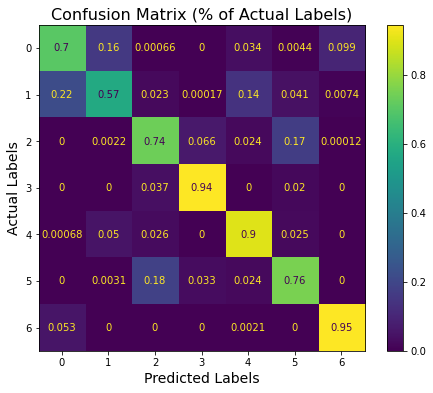

In [15]:
test_score, oof_preds, holdout = train_original(gbc_pipeline)

metrics.append((
    'GradientBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 6. HistGradientBoosting

In [16]:
# Gradient Boosting Classifier
hgbc_pipeline = make_pipeline(
    HistGradientBoostingClassifier(
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85767 in 10.45s.
Fold 1 Accuracy: 0.85185 in 10.93s.
Fold 2 Accuracy: 0.86508 in 11.04s.
Fold 3 Accuracy: 0.85556 in 11.06s.
Fold 4 Accuracy: 0.85397 in 11.06s.
Fold 5 Accuracy: 0.8582 in 11.15s.
Fold 6 Accuracy: 0.86085 in 10.29s.
Fold 7 Accuracy: 0.86395 in 11.13s.

Average CV Accuracy: 0.85839
Worst CV Accuracy: 0.85185
Holdout Accuracy: 0.73682
Training Time: 87.1s



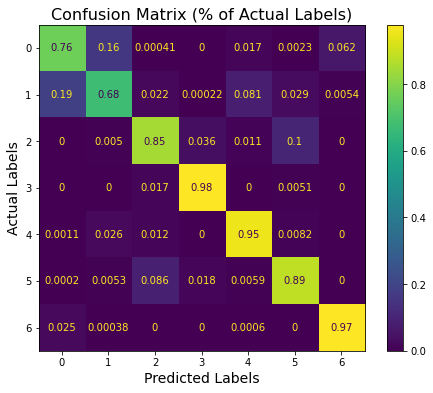

In [17]:
test_score, oof_preds, holdout = train_original(hgbc_pipeline)

metrics.append((
    'HistGradientBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# XGBoost

We test out several XGBoost models:

1. Vanilla
2. Random Forest
3. DART

## 1. XGBoost Baseline

In [18]:
# XGBoost Classifier
xgb_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'gbtree',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.8545 in 1.95s.
Fold 1 Accuracy: 0.84815 in 2.06s.
Fold 2 Accuracy: 0.86138 in 2.04s.
Fold 3 Accuracy: 0.86561 in 2.0s.
Fold 4 Accuracy: 0.85926 in 2.03s.
Fold 5 Accuracy: 0.85397 in 2.02s.
Fold 6 Accuracy: 0.85767 in 2.01s.
Fold 7 Accuracy: 0.86342 in 2.06s.

Average CV Accuracy: 0.85799
Worst CV Accuracy: 0.84815
Holdout Accuracy: 0.74154
Training Time: 16.16s



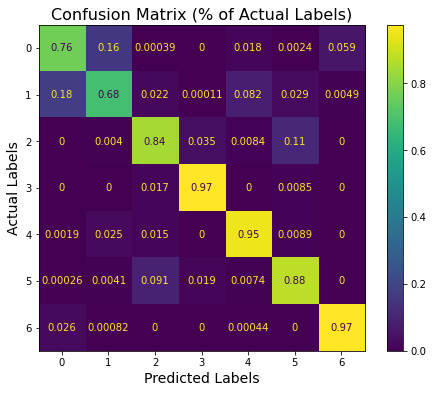

In [19]:
test_score, oof_preds, holdout = train_original(xgb_pipeline)

metrics.append((
    'XGBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. XGBoost (Random Forest)

In [20]:
# XGBoost Classifier
xgbrf_pipeline = make_pipeline(
    XGBRFClassifier(
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.74974 in 2.35s.
Fold 1 Accuracy: 0.74339 in 2.4s.
Fold 2 Accuracy: 0.76138 in 2.41s.
Fold 3 Accuracy: 0.7545 in 2.38s.
Fold 4 Accuracy: 0.75767 in 2.41s.
Fold 5 Accuracy: 0.75979 in 2.39s.
Fold 6 Accuracy: 0.75503 in 2.38s.
Fold 7 Accuracy: 0.76125 in 2.41s.

Average CV Accuracy: 0.75534
Worst CV Accuracy: 0.74339
Holdout Accuracy: 0.5674
Training Time: 19.14s



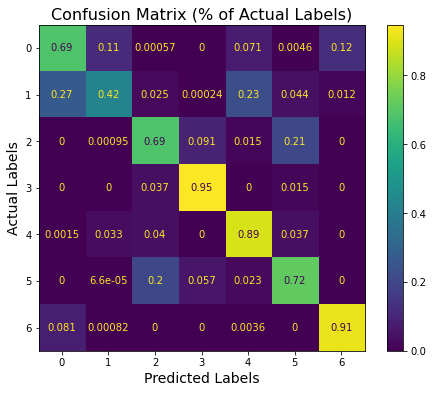

In [21]:
test_score, oof_preds, holdout = train_original(xgbrf_pipeline)

metrics.append((
    'XGBoost_RF', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. XGBoost (DART)

In [22]:
# XGBoost Classifier
xgbdart_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'dart',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        rate_drop = 0.1,
        skip_drop = 0.5,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.84286 in 5.69s.
Fold 1 Accuracy: 0.83386 in 5.71s.
Fold 2 Accuracy: 0.84339 in 5.68s.
Fold 3 Accuracy: 0.83333 in 5.78s.
Fold 4 Accuracy: 0.84074 in 5.79s.
Fold 5 Accuracy: 0.83333 in 5.7s.
Fold 6 Accuracy: 0.84339 in 5.74s.
Fold 7 Accuracy: 0.8486 in 5.95s.

Average CV Accuracy: 0.83994
Worst CV Accuracy: 0.83333
Holdout Accuracy: 0.71045
Training Time: 46.05s



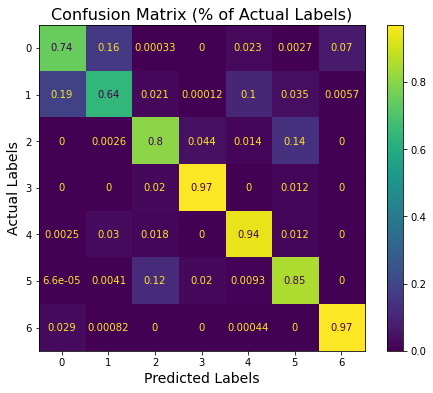

In [23]:
test_score, oof_preds, holdout = train_original(xgbdart_pipeline)

metrics.append((
    'XGBoost_DART', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# LightGBM

1. Vanilla
2. Random Forest
3. DART
4. GOSS

## 1. LightGBM (Baseline)

In [24]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'gbdt',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85661 in 3.26s.
Fold 1 Accuracy: 0.85026 in 3.04s.
Fold 2 Accuracy: 0.8582 in 3.05s.
Fold 3 Accuracy: 0.85926 in 3.08s.
Fold 4 Accuracy: 0.85714 in 3.04s.
Fold 5 Accuracy: 0.86296 in 3.02s.
Fold 6 Accuracy: 0.86243 in 3.02s.
Fold 7 Accuracy: 0.86236 in 2.99s.

Average CV Accuracy: 0.85865
Worst CV Accuracy: 0.85026
Holdout Accuracy: 0.73493
Training Time: 24.5s



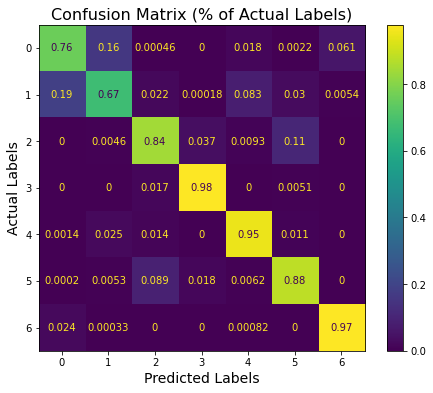

In [25]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. LightGBM (Random Forest)

In [26]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'rf',
        metric = 'multi_logloss',
        colsample_bynode = 0.8,
        subsample = 0.8,
        subsample_freq = 1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.77672 in 2.87s.
Fold 1 Accuracy: 0.75926 in 2.91s.
Fold 2 Accuracy: 0.78783 in 2.95s.
Fold 3 Accuracy: 0.77884 in 2.87s.
Fold 4 Accuracy: 0.78042 in 2.91s.
Fold 5 Accuracy: 0.7619 in 2.88s.
Fold 6 Accuracy: 0.77778 in 2.87s.
Fold 7 Accuracy: 0.78719 in 2.84s.

Average CV Accuracy: 0.77624
Worst CV Accuracy: 0.75926
Holdout Accuracy: 0.61019
Training Time: 23.1s



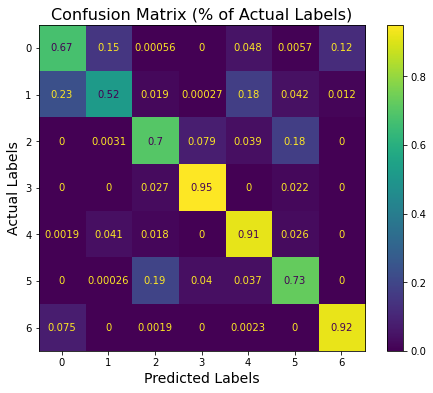

In [27]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_RF', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. LightGBM (DART)

In [28]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'dart',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.84021 in 3.14s.
Fold 1 Accuracy: 0.83333 in 3.15s.
Fold 2 Accuracy: 0.84921 in 3.12s.
Fold 3 Accuracy: 0.84392 in 3.2s.
Fold 4 Accuracy: 0.83704 in 3.14s.
Fold 5 Accuracy: 0.83386 in 3.14s.
Fold 6 Accuracy: 0.8418 in 3.19s.
Fold 7 Accuracy: 0.8486 in 3.14s.

Average CV Accuracy: 0.841
Worst CV Accuracy: 0.83333
Holdout Accuracy: 0.70233
Training Time: 25.22s



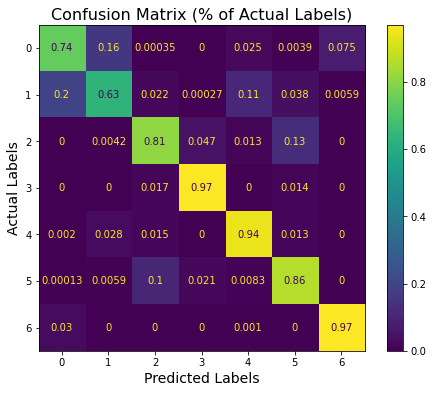

In [29]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_DART', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. LightGBM (GOSS)

In [30]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'goss',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85397 in 3.29s.
Fold 1 Accuracy: 0.84339 in 3.42s.
Fold 2 Accuracy: 0.86667 in 3.33s.
Fold 3 Accuracy: 0.85714 in 3.35s.
Fold 4 Accuracy: 0.84709 in 3.37s.
Fold 5 Accuracy: 0.8545 in 3.33s.
Fold 6 Accuracy: 0.86402 in 3.33s.
Fold 7 Accuracy: 0.85707 in 3.36s.

Average CV Accuracy: 0.85548
Worst CV Accuracy: 0.84339
Holdout Accuracy: 0.7387
Training Time: 26.78s



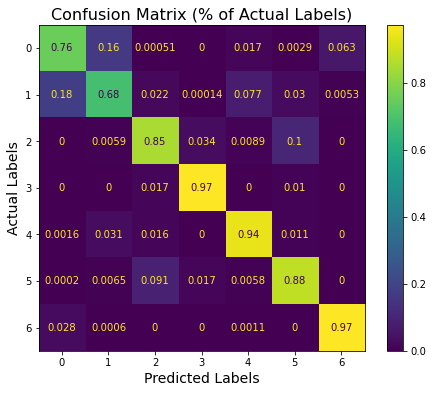

In [31]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_GOSS', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# CatBoost

In [32]:
# LightGBM Classifier
catboost_pipeline = make_pipeline(
    CatBoostClassifier(
        eval_metric = 'MultiClass',
        boosting_type = 'Plain',
        verbose = False,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85608 in 9.45s.
Fold 1 Accuracy: 0.86085 in 9.28s.
Fold 2 Accuracy: 0.8709 in 9.3s.
Fold 3 Accuracy: 0.85291 in 9.25s.
Fold 4 Accuracy: 0.85344 in 9.21s.
Fold 5 Accuracy: 0.84497 in 9.26s.
Fold 6 Accuracy: 0.85767 in 9.22s.
Fold 7 Accuracy: 0.86977 in 9.27s.

Average CV Accuracy: 0.85832
Worst CV Accuracy: 0.84497
Holdout Accuracy: 0.73696
Training Time: 74.23s



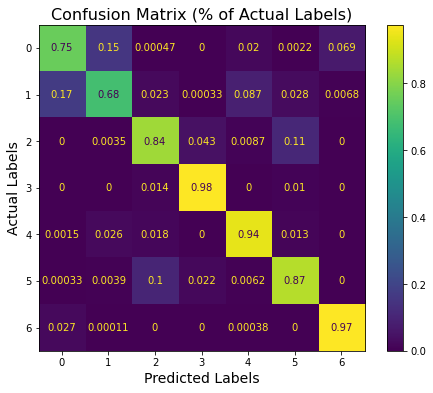

In [33]:
test_score, oof_preds, holdout = train_original(catboost_pipeline)

metrics.append((
    'CatBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Summary

In [35]:
pd.DataFrame.from_records(
    data = metrics,
    columns = ['model','accuracy','holdout','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('accuracy')

,model,accuracy,holdout,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
0,AdaBoost,0.345723,0.264907,0.478033,0.094383,0.047567,0.000000,0.807855,0.752614,0.227411
7,XGBoost_RF,0.755341,0.567401,0.687786,0.423474,0.686858,0.947189,0.889131,0.716052,0.914278
10,LightGBM_RF,0.776243,0.610193,0.672429,0.517623,0.701652,0.950596,0.913542,0.727362,0.920654
4,GradientBoost,0.796680,0.652524,0.703639,0.572663,0.736241,0.942078,0.898268,0.756231,0.945341
8,XGBoost_DART,0.839937,0.710445,0.744134,0.643531,0.801429,0.967632,0.937815,0.849148,0.970082
2,Bagging,0.840929,0.728760,0.756348,0.664969,0.842566,0.976150,0.955407,0.872361,0.965014
11,LightGBM_DART,0.840995,0.702329,0.738697,0.629787,0.808305,0.969336,0.942043,0.859933,0.969210
12,LightGBM_GOSS,0.855480,0.738703,0.755093,0.684859,0.848132,0.972743,0.941088,0.879858,0.970681
6,XGBoost,0.857994,0.741538,0.763645,0.684717,0.841465,0.974446,0.949816,0.878543,0.972316
13,CatBoost,0.858325,0.736959,0.753915,0.684230,0.835541,0.976150,0.941497,0.867561,0.972970
